In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from src.models.network import BuddingLayer
from src.models.training import *

In [26]:
BATCH_SIZE = 64
EPOCHS = 50

In [27]:
class Net(nn.Module):
    def __init__(self, in_features: int, out_size: int):
        super().__init__()
        
        n_in = in_features

        self.bl1 = nn.Linear(n_in, 10)
        self.bl2 = nn.Linear(10, 9)
        self.blout = nn.Linear(9, out_size)
        
    def forward(self, x):
        x = F.relu(self.bl1(x))
        x = F.relu(self.bl2(x))
        x = self.blout(x)

        return x

In [28]:
class CapacityNet(nn.Module):
    def __init__(self, in_features: int, out_size: int, window_size: int, threshold: float):
        super().__init__()

        self.window_size = window_size
        self.threshold = threshold
        
        n_in = in_features

        self.bl1 = BuddingLayer(n_in, 10, self.window_size)
        self.bl2 = BuddingLayer(10, 9, self.window_size)
        self.blout = BuddingLayer(9, out_size, self.window_size)

        self.param_state = set(self.state_dict().keys())
        
    def get_extra_params(self):
        current_state = set(self.state_dict().keys())
        diff = current_state - self.param_state
        self.param_state = current_state
        return diff
    
    def get_saturation(self, best_lipschitz):
        if best_lipschitz is not None:
            return best_lipschitz < self.threshold
        return None

    def forward(self, x):
        x, lip = self.bl1(x)
        x = F.relu(x)
        print(lip)
        saturation = self.get_saturation(lip)
        x, lip = self.bl2(x, saturation)
        x = F.relu(x)
        print(lip)
        saturation = self.get_saturation(lip)
        x, lip = self.blout(x, saturation)

        return x

In [29]:
input_features = "../data/processed/obesity_features.csv"
input_target = "../data/processed/obesity_target.csv"

X = np.genfromtxt(input_features, delimiter=',')
y = np.genfromtxt(input_target, delimiter=',')
X_train, X_test, y_train, y_test = data_split(X, y)

In [30]:
trainloader = DataLoader(X_train, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(X_test, batch_size=BATCH_SIZE, shuffle=True)

In [31]:
torch.manual_seed(101)
model = CapacityNet(X_train.shape[1], len(np.unique(y_train)), window_size=5, threshold=0.01)
benchmark = Net(X_train.shape[1], len(np.unique(y_train)))

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)
bench_optim = Adam(benchmark.parameters(), lr=0.01)

In [33]:
losses = []
for epoch in range(EPOCHS):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    print(f"Epoch: {epoch+1}  Loss: {loss.item():10.3f}")
    print(f"SATURATION:\nBL2: {model.bl2.saturated_neurons}\nBLout: {model.blout.saturated_neurons}")
    #print(model.state_dict())
    #print(model.get_extra_params())
    print("=========================================================================================\n")
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

None
None
Epoch: 1  Loss:      1.982
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

None
None
Epoch: 2  Loss:      1.969
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

None
None
Epoch: 3  Loss:      1.957
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

None
None
Epoch: 4  Loss:      1.947
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([False, False, False, False, False, False, False, False, False])

None
None
Epoch: 5  Loss:      1.937
SATURATION:
BL2: tensor([False, False, False, False, False, False, False, False, False, False])
BLout: tensor([

tensor([0.0610, 0.0591, 0.1190, 0.0115, 0.1189, 0.0487, 0.0461, 0.0316, 0.0011,
        0.1577])
tensor([6.6917e-02, 2.7416e-02, 4.4440e-02, 4.3170e-02, 4.6968e-06, 3.5886e-03,
        3.6469e-02, 7.1333e-02, 3.6592e-02])
Epoch: 34  Loss:      1.627
SATURATION:
BL2: tensor([False, False, False,  True, False, False, False, False,  True, False])
BLout: tensor([False,  True, False, False,  True,  True, False,  True, False])

tensor([0.0531, 0.0716, 0.1431, 0.0112, 0.1047, 0.0586, 0.0682, 0.0406, 0.0010,
        0.1478])
tensor([5.8308e-02, 2.8822e-02, 4.7686e-02, 3.5738e-02, 4.2796e-06, 3.1995e-03,
        4.4246e-02, 7.9830e-02, 3.4984e-02])
Epoch: 35  Loss:      1.600
SATURATION:
BL2: tensor([False, False, False,  True, False, False, False, False,  True, False])
BLout: tensor([False,  True, False, False,  True,  True, False,  True, False])

tensor([0.0513, 0.0746, 0.1550, 0.0108, 0.0875, 0.0598, 0.0785, 0.0426, 0.0009,
        0.1383])
tensor([4.7167e-02, 2.8832e-02, 4.7686e-02, 2.7398e

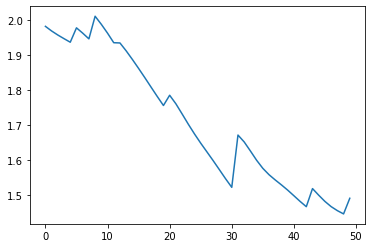

In [34]:
plt.plot(losses)

In [35]:
losses = []
for epoch in range(EPOCHS):
    y_pred = benchmark.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    print(f"Epoch: {epoch+1}  Loss: {loss.item():10.3f}")
    print("=========================================================================================\n")
    
    bench_optim.zero_grad()
    loss.backward()
    bench_optim.step()

Epoch: 1  Loss:      1.970

Epoch: 2  Loss:      1.957

Epoch: 3  Loss:      1.946

Epoch: 4  Loss:      1.935

Epoch: 5  Loss:      1.923

Epoch: 6  Loss:      1.908

Epoch: 7  Loss:      1.891

Epoch: 8  Loss:      1.874

Epoch: 9  Loss:      1.858

Epoch: 10  Loss:      1.840

Epoch: 11  Loss:      1.820

Epoch: 12  Loss:      1.796

Epoch: 13  Loss:      1.771

Epoch: 14  Loss:      1.744

Epoch: 15  Loss:      1.715

Epoch: 16  Loss:      1.682

Epoch: 17  Loss:      1.647

Epoch: 18  Loss:      1.610

Epoch: 19  Loss:      1.570

Epoch: 20  Loss:      1.528

Epoch: 21  Loss:      1.486

Epoch: 22  Loss:      1.442

Epoch: 23  Loss:      1.396

Epoch: 24  Loss:      1.350

Epoch: 25  Loss:      1.304

Epoch: 26  Loss:      1.258

Epoch: 27  Loss:      1.214

Epoch: 28  Loss:      1.173

Epoch: 29  Loss:      1.133

Epoch: 30  Loss:      1.097

Epoch: 31  Loss:      1.062

Epoch: 32  Loss:      1.031

Epoch: 33  Loss:      1.002

Epoch: 34  Loss:      0.975

Epoch: 35  Loss:      0

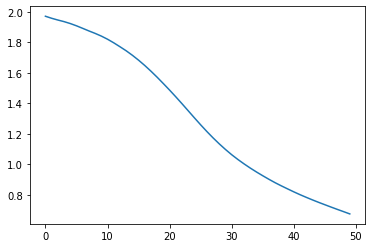

In [36]:
plt.plot(losses)